# <span style="color:#573D1C"> ThemisAI QuickStart: Representation Bias</span>

### <span style="color:#B8D8D8"> Capsa automatically wraps ML workflows to achieve risk-aware learning and deployment.</span>

In this demo, we'll be demonstrating how **CAPSA**, the risk awareness framework that we've developed at **Themis AI**, can be used to detect bias in a low dimensional dataset.

<span style="color:#B8D8D8">Note:</span> We will be utilizing CAPSA's **Histogram Wrapper** metric. **CAPSA** provides several other metrics that we will not be using in this tutorial.

As an ML developer, you are interested in implementing a dynamic representation bias capabilities into your own model. You don't want to implement it yourself, you don't want complexity. And you're interested in simple tools that you can utilize.
**CAPSA** provides you with those vital, yet easy to use tools.

<center>
<div>
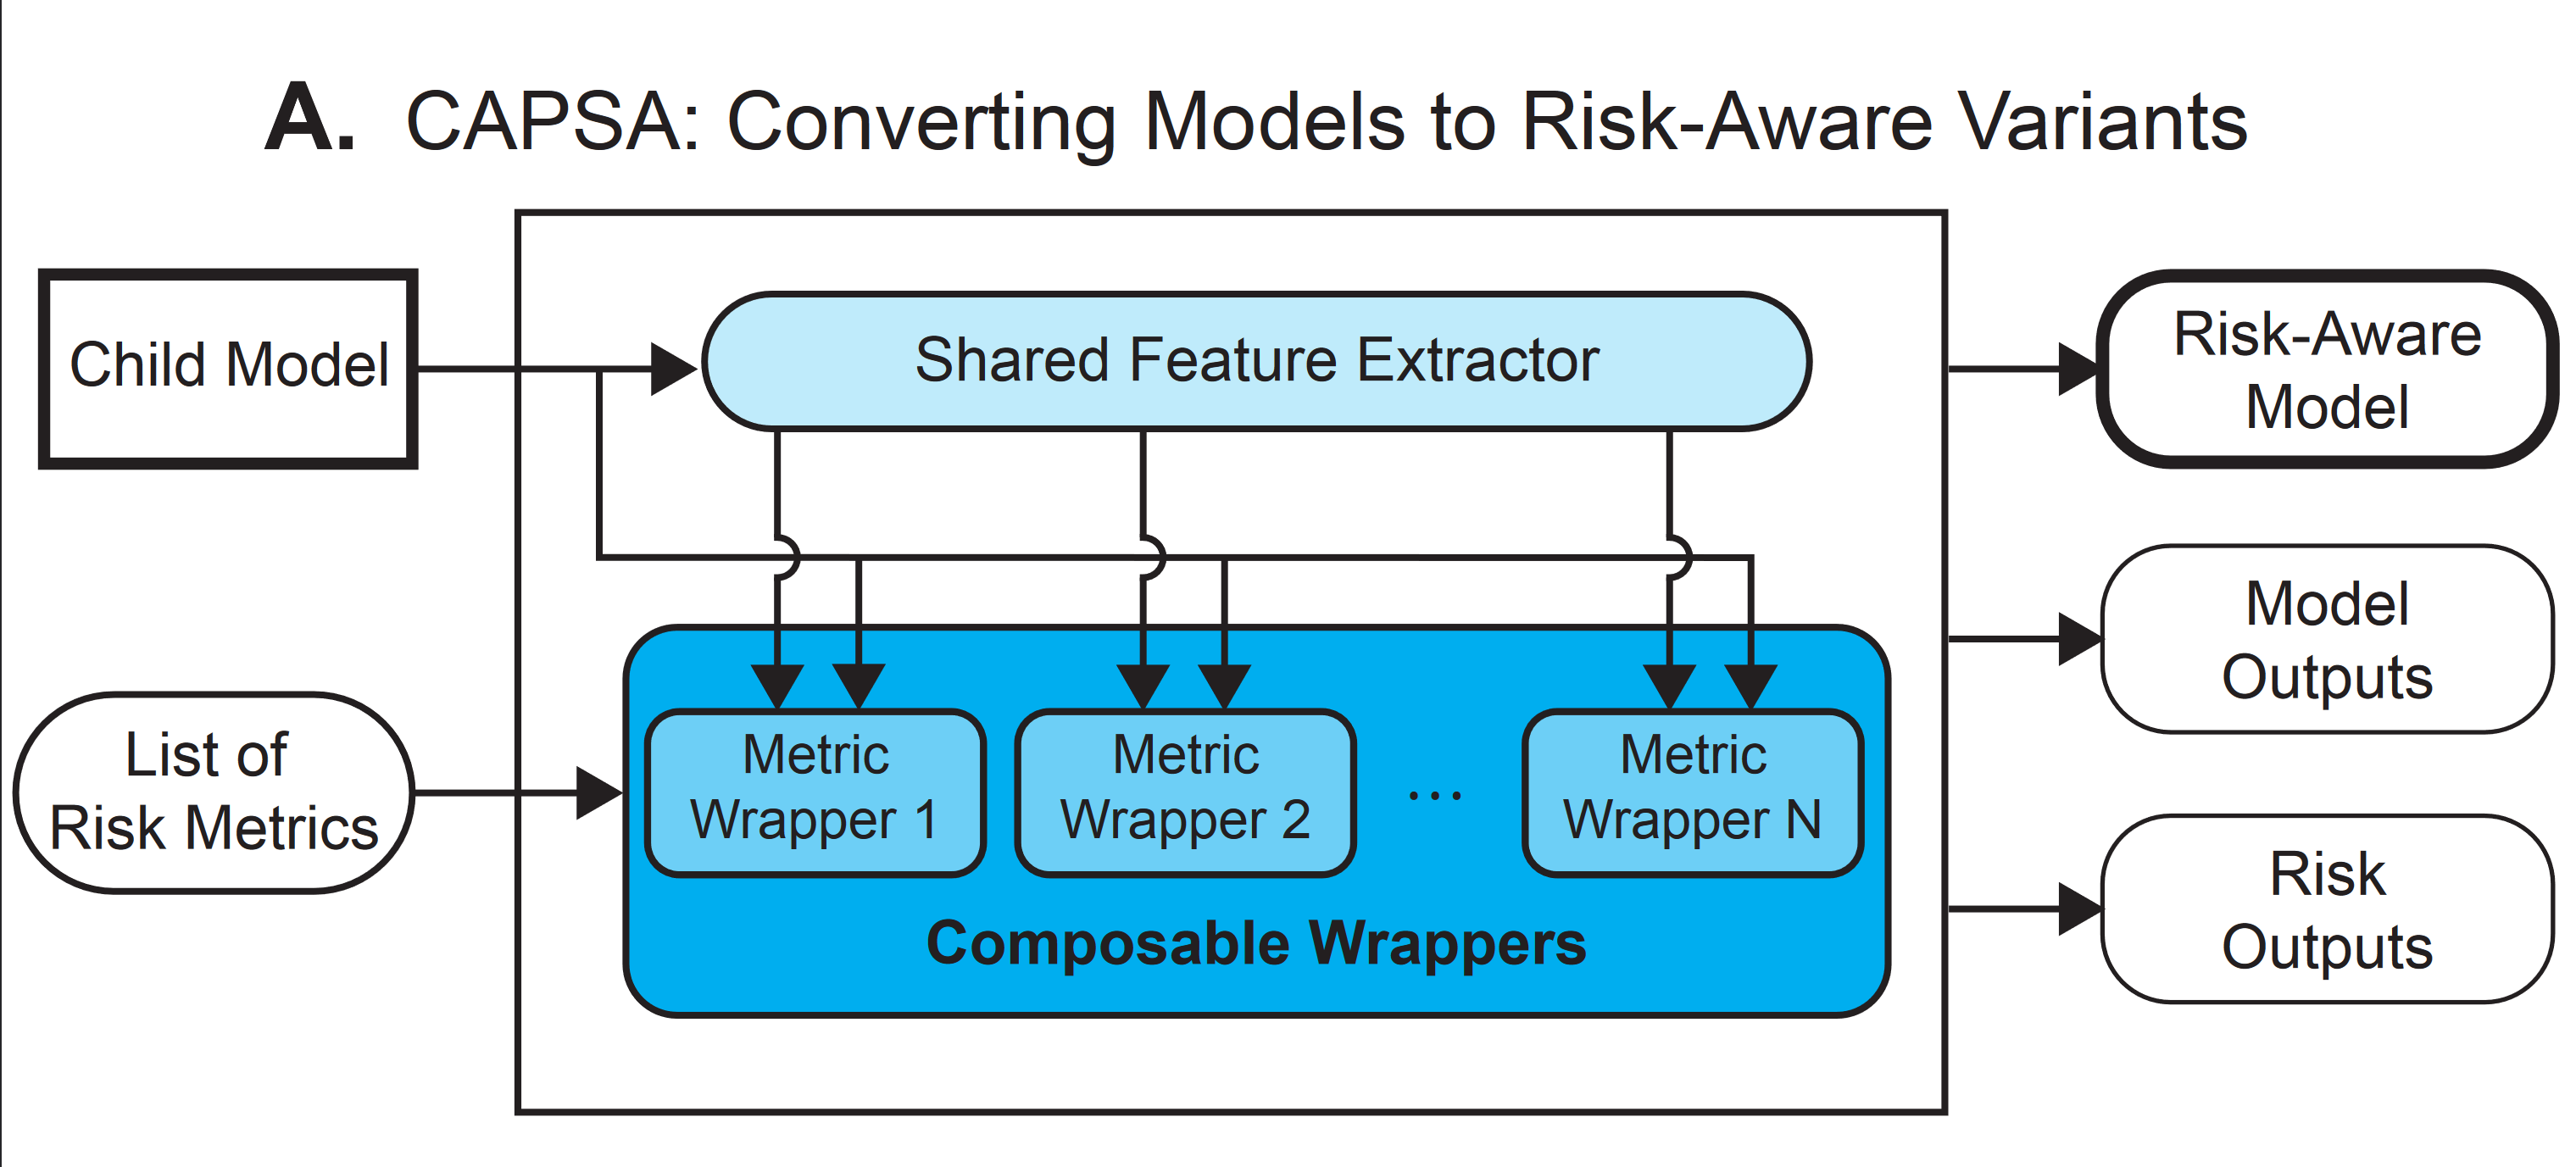
</div>
</center>

**CAPSA**'s main functionality comes from **Wrapper** class, which wraps your model with many different metrics. We call these metrics **Metric Wrappers**. When you apply Wrapper() to your model, you abstract away all the complexities of editing your own model to support these different metrics. On top of that, **CAPSA** supports composability between these metrics, which means you can wrap your own model with many different metrics at the same time.

1. You would start by importing all the necessary tools libraries that you'd be importing in your normal workflow.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from itertools import product
from helper import * 
from capsa import HistogramWrapper,HistogramCallback
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

2. You would have your own training and test dataset ready.

In [2]:
(x_train, y_train), (x_test, y_test) = generate_moon_data_classification()

3. You might want to visualize your own dataset to get a better understanding of your own data. So you plot your training dataset into a graph.

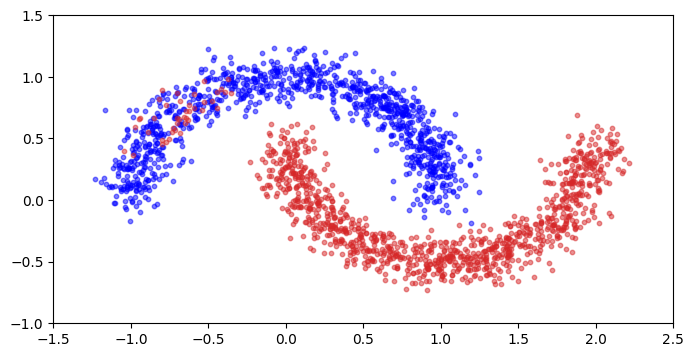

In [3]:
plot_for_moons(x_train, y_train)

4. You import **CAPSA**'s wrap() function. The wrap function helps integrate you to **CAPSA** metric wrappers seamlessly. You only need to pass a predefined model, and which metrics you prefer to wrap the model with. 

The current options are:
- <span style="color:yellow">**Bias**</span> (Representation Bias): Bias uncovers the imbalance in the feature space of a dataset and captures whether certain combinations of features are more prevalent than others.
- <span style="color:yellow">**Aleatoric**</span> (Aleatoric Uncertainty): Aleatoric captures the noise in the data: mislabeled datapoints, ambigious labels, classes with low seperation, etc.
- <span style="color:yellow">**Epistemic**</span> (Epistemic Uncertainty): Epistemic measures uncertainty in the model's predictive process - this captures scenarios such as examples that are "hard" to learn.

In [4]:
from capsa import HistogramWrapper

5. Just like in your normal workflow, you'd have your own pre-defined model.

In [16]:
user_model = get_model()

In [37]:
bin_amt = 6
histogram_model = HistogramWrapper(user_model,num_bins=bin_amt)

In [38]:
histogram_model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
            )

In [39]:
histogram_model.fit(x_train,y_train,epochs = 2,callbacks=[HistogramCallback()])

Epoch 1/2
1313/1313 [==============================] - 3s 2ms/step - histogram_loss: 0.1441 - histogram_binary_accuracy: 0.8531
Epoch 2/2
1313/1313 [==============================] - 2s 2ms/step - histogram_loss: 0.0195 - histogram_binary_accuracy: 0.9762


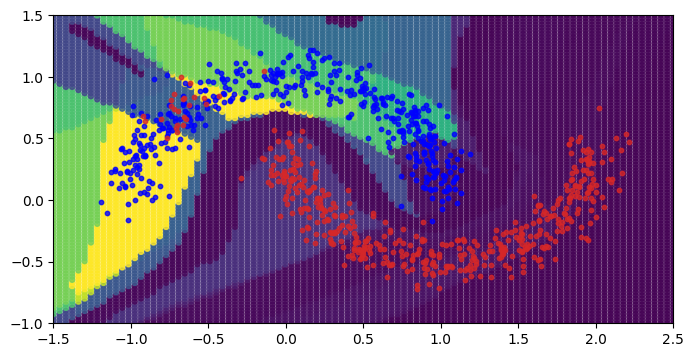

In [41]:

mesh_grid = get_grid()
bias_values = histogram_model(mesh_grid)[1]
histogram_plot_w_mesh(x_test,y_test,bias_values,mesh_grid)


In [8]:

#value_range = tf.transpose(tf.linspace(histogram_model.histogram_layer.minimums,histogram_model.histogram_layer.maximums,num=20,axis=0))

value_range = np.array([histogram_model.histogram_layer.minimums,histogram_model.histogram_layer.maximums])

In [94]:
x = tf.cast(x_train.T[0],tf.float32)
y = tf.cast(x_train.T[1],tf.float32)

In [42]:
def get2dHistogram(x, y, value_range, nbins=100, dtype=tf.dtypes.float32):
    
    x_range = value_range[0]
    y_range = value_range[1]
    
    histy_bins = tf.histogram_fixed_width_bins(y, y_range, nbins=nbins, dtype=dtype)
    
    H = tf.map_fn(lambda i: tf.histogram_fixed_width(x[histy_bins == i], x_range, nbins=nbins), tf.range(nbins))
    return H # Matrix!

In [108]:
H = get2dHistogram(x,y,value_range.T,nbins=7)

<tf.Tensor: shape=(), dtype=int32, numpy=42000>

In [111]:
hist_probs = tf.divide(H,tf.reduce_sum(H))

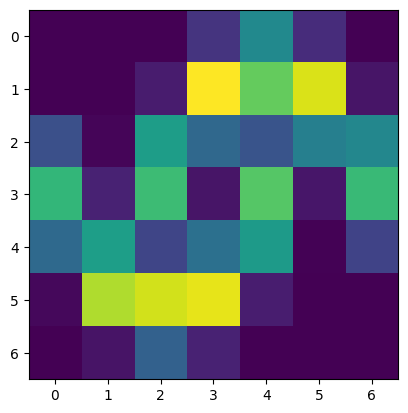

In [113]:
plt.imshow(hist_probs)

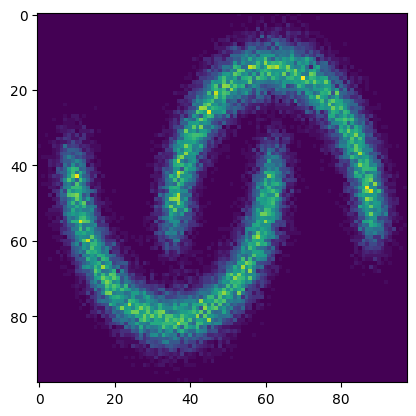

In [54]:
for i in range(2,100,2):
    H = get2dHistogram(tf.cast(x_train.T[0],tf.float32),tf.cast(x_train.T[1],tf.float32),value_range.T,nbins=i)
    plt.imshow(H)
    plt.savefig(str(i)+".png")

In [7]:
mesh_grid.shape

(10000, 2)

In [11]:
x = tf.convert_to_tensor([[3,1],[1,6],[7,9]])
y = tf.convert_to_tensor([5,2])

In [13]:
print(x)
print(y)

tf.Tensor(
[[3 1]
 [1 6]
 [7 9]], shape=(3, 2), dtype=int32)
tf.Tensor([5 2], shape=(2,), dtype=int32)


In [72]:
hist_probs = tf.divide(
                histogram_model.histogram_layer.frequencies, tf.reduce_sum(histogram_model.histogram_layer.frequencies, axis=0)
            )
#histogram_model.histogram_layer.frequencies

In [78]:
tf.reduce_sum(histogram_model.histogram_layer.frequencies, axis=0)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([42000., 42000.], dtype=float32)>

In [15]:
x.shape[1:]

TensorShape([2])

In [86]:
histograms_this_batch = tfp.stats.histogram(
                testX,
                histogram_model.histogram_layer.edges,
                axis=0,
                extend_lower_interval=True,
                extend_upper_interval=True,
            )

In [85]:
testX = tf.cast(x_train[0:10],dtype=tf.float32)

In [87]:
histograms_this_batch

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 2.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>

In [88]:
histogram_model.histogram_layer.edges

<tf.Variable 'histogram_layer/Variable:0' shape=(51, 2) dtype=float32, numpy=
array([[-1.3577126 , -0.8270047 ],
       [-1.2837833 , -0.783215  ],
       [-1.209854  , -0.7394253 ],
       [-1.1359248 , -0.6956357 ],
       [-1.0619955 , -0.65184593],
       [-0.9880662 , -0.6080563 ],
       [-0.9141369 , -0.5642666 ],
       [-0.84020764, -0.52047694],
       [-0.7662783 , -0.47668725],
       [-0.692349  , -0.43289757],
       [-0.61841977, -0.38910788],
       [-0.54449046, -0.34531823],
       [-0.47056115, -0.30152857],
       [-0.3966319 , -0.2577389 ],
       [-0.32270265, -0.2139492 ],
       [-0.24877334, -0.17015952],
       [-0.17484403, -0.12636983],
       [-0.10091472, -0.08258015],
       [-0.02698541, -0.03879046],
       [ 0.04694378,  0.00499922],
       [ 0.12087309,  0.04878891],
       [ 0.1948024 ,  0.09257853],
       [ 0.2687317 ,  0.13636822],
       [ 0.34266102,  0.1801579 ],
       [ 0.41659033,  0.22394753],
       [ 0.49051952,  0.26773727],
       [ 0.5